# This is my attempt at tournament 101

Using principal component analysis and logistic regression I was able to get a high enough log loss, consistency and concordance. However, the submission did not score high enough on the 'original' metric. Hopefully this is because I am submitting with 2 hours to go for this week!

In [1]:
import numpy as np
import math 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

In [2]:
df = pd.read_csv(filepath_or_buffer='numerai_training_data.csv')

X = df[df.columns[3:-1]]
X = X.values


Checking data structure

In [3]:
for i in range(0, X.shape[1]):
    #show mean and standard deviation for each column
    deviation = np.std(X[:,i])
    mean = np.mean(X[:,i])
    print("Mean is {0:.2f}, standard dev. is {1:.2f} for column {2}".format(mean, deviation,i))

Mean is 0.47, standard dev. is 0.13 for column 0
Mean is 0.46, standard dev. is 0.10 for column 1
Mean is 0.48, standard dev. is 0.12 for column 2
Mean is 0.44, standard dev. is 0.11 for column 3
Mean is 0.51, standard dev. is 0.11 for column 4
Mean is 0.48, standard dev. is 0.12 for column 5
Mean is 0.52, standard dev. is 0.12 for column 6
Mean is 0.56, standard dev. is 0.11 for column 7
Mean is 0.52, standard dev. is 0.10 for column 8
Mean is 0.47, standard dev. is 0.12 for column 9
Mean is 0.52, standard dev. is 0.11 for column 10
Mean is 0.50, standard dev. is 0.10 for column 11
Mean is 0.49, standard dev. is 0.12 for column 12
Mean is 0.51, standard dev. is 0.14 for column 13
Mean is 0.54, standard dev. is 0.12 for column 14
Mean is 0.46, standard dev. is 0.10 for column 15
Mean is 0.52, standard dev. is 0.12 for column 16
Mean is 0.48, standard dev. is 0.13 for column 17
Mean is 0.54, standard dev. is 0.12 for column 18
Mean is 0.48, standard dev. is 0.09 for column 19
Mean is 0.

In [4]:
Y = df['target'].values

In [5]:
df.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
0,n2b2e3dd163cb422,era1,train,0.43487,0.44645,0.25802,0.37149,0.62235,0.67451,0.68103,...,0.52962,0.42439,0.51680,0.46297,0.57426,0.57946,0.49646,0.48968,0.54194,1
1,n177021a571c94c8,era1,train,0.50038,0.39216,0.38394,0.51213,0.36660,0.46911,0.68204,...,0.51669,0.48445,0.57587,0.59860,0.67558,0.45577,0.80908,0.50287,0.61629,0
2,n7830fa4c0cd8466,era1,train,0.47416,0.34143,0.39528,0.46337,0.72953,0.45962,0.47869,...,0.41458,0.34804,0.29058,0.51382,0.36389,0.80602,0.39253,0.41821,0.58679,0
3,nc594a184cee941b,era1,train,0.48759,0.55903,0.43987,0.38834,0.44650,0.46389,0.70749,...,0.28776,0.42881,0.55402,0.53695,0.48793,0.62432,0.52898,0.49009,0.49557,0
4,nc5ab8667901946a,era1,train,0.23433,0.55499,0.47849,0.56990,0.64945,0.47152,0.62085,...,0.64405,0.32416,0.33193,0.58065,0.44587,0.47770,0.44020,0.47895,0.57978,0


This is very unstructured, poorly correlated data so we do some dimensionality reduction

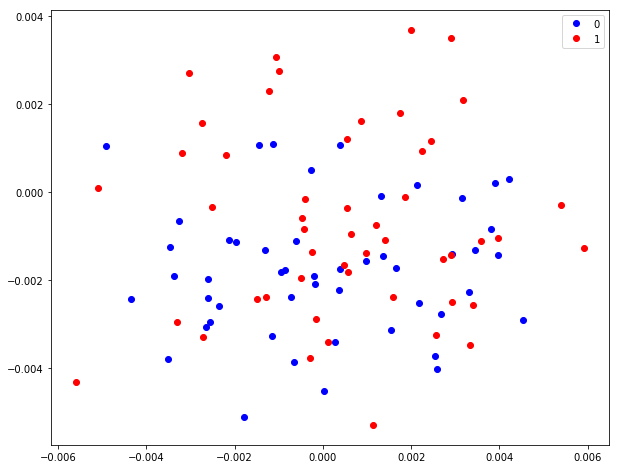

In [6]:
only_0s = df.loc[df['target'] == 0.0]
only_1s = df.loc[df['target'] == 1.0]

X_0s = only_0s[only_0s.columns[3:-1]].values
X_1s = only_1s[only_1s.columns[3:-1]].values

pca0s = PCA(n_components=5)
pca0s.fit(X_0s.T)
pca1s = PCA(n_components=5)
pca1s.fit(X_1s.T)


fig = plt.figure(figsize=(10,8))
plt.plot(pca0s.components_[0][0:50], pca0s.components_[1][0:50],'bo',label='0')
plt.plot(pca1s.components_[0][0:50], pca1s.components_[1][0:50],'ro',label='1')
plt.legend(loc='best')

In [7]:
pca = PCA(n_components=5)
pca.fit(X)

feature_df = pd.DataFrame()
pcas = pca.transform(X)
feature_df['pca1'] = pcas[:,0]
feature_df['pca2'] = pcas[:,1]
feature_df['pca3'] = pcas[:,2]
feature_df['pca4'] = pcas[:,3]
feature_df['pca5'] = pcas[:,4]

feature_df['target'] = Y

feature_df.head(3)

,pca1,pca2,pca3,pca4,pca5,target
0,0.073779,-0.238492,-0.043349,-0.124319,-0.195636,1
1,0.340865,-0.476039,0.199380,-0.317527,0.230062,0
2,-0.446399,-0.145170,0.073536,0.492985,-0.460394,0


In [8]:
def model_maker(model, xs, ys, use_rbf=False):
    poly=PolynomialFeatures(degree=3)
    xs = poly.fit_transform(xs)
    X_train, X_test, Y_train, Y_test = train_test_split(xs, ys, test_size=0.15)
    clf = model
    clf.fit(X_train, Y_train)
    avg_dif = abs(clf.predict(X_test) - Y_test)
    mean = np.mean(avg_dif)
    score = clf.score(X_test, Y_test)
    #must check the log loss for the competition
    loss = log_loss(Y_test, clf.predict_proba(X_test))
    print("Score is {0:.2f}".format(score))
    print("Log loss is {0:.6f}".format(loss))
    print("Model is {}".format(model))

In [9]:
model_maker(LogisticRegression(C=0.1), feature_df[['pca1','pca2','pca3','pca4','pca5']].values, 
            feature_df['target'].values)


Score is 0.51
Log loss is 0.692619
Model is LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [10]:
estimators = [('poly_features', PolynomialFeatures(degree=3)),
              ('clf', LogisticRegression(C=0.5))]

pipe = Pipeline(estimators)

In [11]:
pipe.fit(feature_df[['pca1','pca2','pca3','pca4','pca5']].values, feature_df['target'].values)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('clf', LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [12]:
tournie_df = pd.read_csv(filepath_or_buffer='numerai_tournament_data.csv')
X_pred = tournie_df[tournie_df.columns[3:-1]]
X_pred = X_pred.values

pca_pred_features = PCA(n_components=5)
pca_pred_features.fit(X_pred)
pred_features = pca_pred_features.transform(X_pred)

In [13]:
predictions = pipe.predict_proba(pred_features)
probs = predictions[:,1]
results_df = pd.DataFrame(data={'probability':probs})
ids = tournie_df["id"]
joined = pd.DataFrame(ids).join(results_df)

print("Writing predictions to predictions.csv")
# Save the predictions out to a CSV file
joined.to_csv("predictions.csv", index=False)
# Now you can upload these predictions on numer.ai

Writing predictions to predictions.csv


In [14]:
#Can test the consistency locally
def test_consistency(filename, prediction_data):
    submission_data = pd.read_csv(filepath_or_buffer=filename)
    validation_data = prediction_data[prediction_data.data_type == "validation"]
    validation_submission_data = submission_data[submission_data.id.isin(validation_data.id.values)]
    validation_eras = np.unique(validation_data.era.values)
    num_eras = len(validation_eras)

    better_than_random_era_count = 0
    for era in validation_eras:
        era_data = validation_data[validation_data.era == era]
        submission_era_data = validation_submission_data[validation_submission_data.id.isin(era_data.id.values)]
        era_data = era_data.sort_values(["id"])
        submission_era_data = submission_era_data.sort_values(["id"])
        logloss = log_loss(era_data.target.values, submission_era_data.probability.values)
        if logloss < -math.log(0.5):
            better_than_random_era_count += 1

        consistency = better_than_random_era_count / num_eras * 100
    
    print("Consistency: {0:.2f}".format(consistency))

In [15]:
pred_data = pd.read_csv(filepath_or_buffer='/Users/michael/ML/numerai/numerai_tournament_data.csv')

test_consistency('predictions.csv', pred_data)

Consistency: 75.00


This consistency is at the threshold value of 75%.